<a href="https://colab.research.google.com/github/aledp/ceia_PNL_aledp/blob/main/Resolucion_Desafio_3_AlejandraDelPorto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consigna del desafío 3




* Entrenar un modelo de lenguaje basado en arquitectura recurrente, utilizando un corpus mayor al utilizado en clase.

* Explorar diferentes variantes de arquitecturas (GRU, LSTM, Bidireccionales, Cantidad de capas y neuronas, tamaño de contexto máximo)

* El objetivo principal sería lograr que durante el entrenamiento baje la perplejidad.
* Con el modelo que les haya resultado mejor, realizar algunas pruebas de generación de secuencias utilizando greedy search, beam search determinista y beam search estocástico (aquí pueden incluso variar la temperatura).

In [254]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
import multiprocessing

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [255]:
#!pip install python-docx
from docx import Document

In [256]:
#import nltk
#from nltk.tokenize import sent_tokenize, word_tokenize

In [257]:
import seaborn as sns

In [258]:
import tensorflow as tf
from tensorflow import keras
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
# Configura Keras para usar la GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


GPU disponible: []


# Carga del corpus

In [261]:
## CARGA PARA GOOGLE COLAB

from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')
# ruta del archivo txt
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/NLP_TP/Desafio3/CorpusLibroWord.docx'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [260]:
## CARGA PARA PC
#pip install python-docx
#from docx import Document
## ruta del archivo txt
#ruta_archivo = './Desafio3/CorpusLibroWord.docx'


In [8]:
# Crear un objeto Document para leer el archivo de Word
documento = Document(ruta_archivo)

# Extraer oraciones
oraciones = []
for para in documento.paragraphs:
    oraciones.extend(para.text.split("."))

# Crear DataFrame
df = pd.DataFrame({'Oracion': oraciones})

# Eliminar filas vacías
df = df[df['Oracion'] != '']

# Restablecer los índices del DataFrame
df.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame
print(df.head(10))

                                             Oracion
0                               De animales a dioses
1                     Breve historia de la humanidad
2                                  YUVAL NOAH HARARI
3                            La revolución cognitiva
4                                           FIGURA 1
5       Impresión de una mano efectuada hace unos 30
6  000 años, en la pared de la cueva de Chauvet-P...
7   Tal vez alguien intentó decir «¡Yo estuve aquí!»
8                                                  1
9                          Un animal sin importancia


In [9]:
len(df)

7904

In [10]:
# achico el daset porque es muy grande y por lo tanto costoso de procesar
df = df[6:3000]
df.reset_index(drop=True, inplace=True)
print(df.head(10))

                                             Oracion
0  000 años, en la pared de la cueva de Chauvet-P...
1   Tal vez alguien intentó decir «¡Yo estuve aquí!»
2                                                  1
3                          Un animal sin importancia
4                                       Hace unos 13
5  500 millones de años, materia, energía, tiempo...
6   El relato de estas características fundamenta...
7                                           Unos 300
8  000 años después de su aparición, materia y en...
9   El relato de los átomos, las moléculas y sus ...


In [11]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2994


# Preprocesamiento

In [12]:
# Vistazo a las primeras filas
df.iloc[:15,0]

0     000 años, en la pared de la cueva de Chauvet-P...
1      Tal vez alguien intentó decir «¡Yo estuve aquí!»
2                                                     1
3                             Un animal sin importancia
4                                          Hace unos 13
5     500 millones de años, materia, energía, tiempo...
6      El relato de estas características fundamenta...
7                                              Unos 300
8     000 años después de su aparición, materia y en...
9      El relato de los átomos, las moléculas y sus ...
10                                          Hace unos 3
11    800 millones de años, en un planeta llamado Ti...
12        El relato de los organismos se llama biología
13                                         Hace unos 70
14    000 años, organismos pertenecientes a la espec...
Name: Oracion, dtype: object

In [21]:
# cada linea la guardamos en una lista
text = list(df['Oracion'])
print(type(text))
print()
text

<class 'list'>



['000 años, en la pared de la cueva de Chauvet-Pont-d’Arc, en el sur de Francia',
 ' Tal vez alguien intentó decir «¡Yo estuve aquí!»',
 '1',
 'Un animal sin importancia',
 'Hace unos 13',
 '500 millones de años, materia, energía, tiempo y espacio tuvieron su origen en lo que se conoce como el big bang',
 ' El relato de estas características fundamentales de nuestro universo se llama física',
 'Unos 300',
 '000 años después de su aparición, materia y energía empezaron a conglutinarse en estructuras complejas, llamadas átomos, que después se combinaron en moléculas',
 ' El relato de los átomos, las moléculas y sus interacciones se llama química',
 'Hace unos 3',
 '800 millones de años, en un planeta llamado Tierra, determinadas moléculas se combinaron para formar estructuras particularmente grandes e intrincadas llamadas organismos',
 ' El relato de los organismos se llama biología',
 'Hace unos 70',
 '000 años, organismos pertenecientes a la especie Homo sapiens empezaron a formar estr

In [22]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]
segmented_sentences

[['000',
  'años',
  'en',
  'la',
  'pared',
  'de',
  'la',
  'cueva',
  'de',
  'chauvet',
  'pont',
  'd’arc',
  'en',
  'el',
  'sur',
  'de',
  'francia'],
 ['tal', 'vez', 'alguien', 'intentó', 'decir', '«¡yo', 'estuve', 'aquí', '»'],
 ['1'],
 ['un', 'animal', 'sin', 'importancia'],
 ['hace', 'unos', '13'],
 ['500',
  'millones',
  'de',
  'años',
  'materia',
  'energía',
  'tiempo',
  'y',
  'espacio',
  'tuvieron',
  'su',
  'origen',
  'en',
  'lo',
  'que',
  'se',
  'conoce',
  'como',
  'el',
  'big',
  'bang'],
 ['el',
  'relato',
  'de',
  'estas',
  'características',
  'fundamentales',
  'de',
  'nuestro',
  'universo',
  'se',
  'llama',
  'física'],
 ['unos', '300'],
 ['000',
  'años',
  'después',
  'de',
  'su',
  'aparición',
  'materia',
  'y',
  'energía',
  'empezaron',
  'a',
  'conglutinarse',
  'en',
  'estructuras',
  'complejas',
  'llamadas',
  'átomos',
  'que',
  'después',
  'se',
  'combinaron',
  'en',
  'moléculas'],
 ['el',
  'relato',
  'de',
  'l

In [23]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([334., 375., 390., 514., 392., 400., 226., 154.,  74.,  58.,  34.,
         13.,  11.,   5.,   4.,   4.,   2.,   2.,   1.,   1.]),
 array([ 0.  ,  4.55,  9.1 , 13.65, 18.2 , 22.75, 27.3 , 31.85, 36.4 ,
        40.95, 45.5 , 50.05, 54.6 , 59.15, 63.7 , 68.25, 72.8 , 77.35,
        81.9 , 86.45, 91.  ]),
 <BarContainer object of 20 artists>)

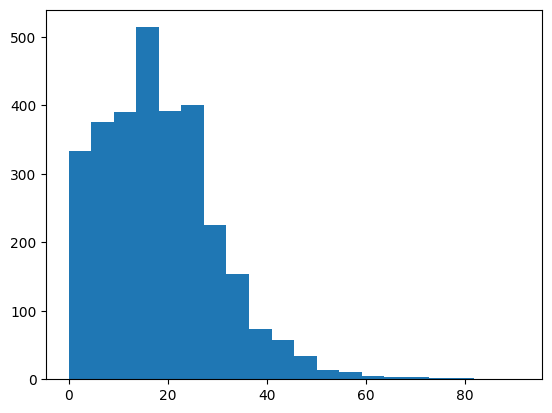

In [24]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [25]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 32


###  Tokenizar

In [26]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [27]:
tokenized_sentences

[[39, 26, 6, 2, 2481, 1, 2, 607, 1, 1814, 3843, 3844, 6, 7, 677, 1, 1196],
 [429, 66, 851, 3845, 202, 3846, 3847, 751, 302],
 [168],
 [10, 224, 42, 494],
 [35, 47, 1815],
 [459,
  55,
  1,
  26,
  2482,
  752,
  89,
  3,
  753,
  369,
  20,
  852,
  6,
  22,
  4,
  12,
  3848,
  21,
  7,
  3849,
  3850],
 [7, 754, 1, 84, 853, 1197, 1, 169, 1816, 12, 608, 755],
 [47, 1198],
 [39,
  26,
  79,
  1,
  20,
  495,
  2482,
  3,
  752,
  370,
  8,
  3851,
  6,
  286,
  496,
  854,
  2483,
  4,
  79,
  12,
  2484,
  6,
  1817],
 [7, 754, 1, 5, 2483, 9, 1817, 3, 25, 1818, 12, 608, 2485],
 [35, 47, 287],
 [2486,
  55,
  1,
  26,
  6,
  10,
  371,
  1441,
  176,
  1442,
  1817,
  12,
  2484,
  18,
  1001,
  286,
  372,
  107,
  73,
  2487,
  854,
  460],
 [7, 754, 1, 5, 460, 12, 608, 288],
 [35, 47, 391],
 [39,
  26,
  460,
  1443,
  8,
  2,
  115,
  45,
  27,
  370,
  8,
  1001,
  286,
  130,
  15,
  496,
  854,
  322],
 [7, 756, 3852, 1, 84, 322, 122, 12, 608, 56],
 [352,
  609,
  461,
  3853,
 

In [28]:
max_context_size+1

33

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [29]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [30]:
print(len(tokenized_sentences_train))
print(len(tokenized_sentences_val))

2395
599


In [31]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tokenized_sentences_train, axis=0)

In [32]:
tok_sent = [] #########################

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [33]:
tok_sent_augm = [] #########################

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [34]:
print(len(tok_sent))
print(len(tok_sent_augm))

4835
4835


In [35]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

print(train_seqs.shape)
print(train_seqs)

(117915, 33)
[[   0    0    0 ...    0 1769   78]
 [   0    0    0 ... 1769   78  144]
 [   0    0    0 ...   78  144  315]
 ...
 [   0    0    0 ...  102   15  484]
 [   0    0    0 ...   15  484    1]
 [   0    0    0 ...  484    1  697]]


In [36]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

print(X.shape)
print(y.shape)

print(type(X))

(117915, 32)
(117915,)
<class 'numpy.ndarray'>


In [37]:
# verificando por error que tengo en el entrenamiento del modelo 1
# Obtener el largo de cada fila
largo_filas = [len(fila) for fila in X]

# Obtener el largo mínimo de todas las filas
largo_minimo = min(largo_filas)

# Obtener el largo máximo de todas las filas
largo_maximo = max(largo_filas)

print("Largo de cada fila:", largo_filas)
print("Largo mínimo de todas las filas:", largo_minimo)
print("Largo máximo de todas las filas:", largo_maximo)

Largo de cada fila: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

In [38]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'que',
 5: 'los',
 6: 'en',
 7: 'el',
 8: 'a',
 9: 'las',
 10: 'un',
 11: 'una',
 12: 'se',
 13: 'no',
 14: 'por',
 15: 'más',
 16: 'es',
 17: 'del',
 18: 'para',
 19: 'con',
 20: 'su',
 21: 'como',
 22: 'lo',
 23: 'o',
 24: 'pero',
 25: 'sus',
 26: 'años',
 27: 'sapiens',
 28: 'humanos',
 29: 'si',
 30: 'al',
 31: 'son',
 32: 'solo',
 33: 'manera',
 34: 'eran',
 35: 'hace',
 36: 'entre',
 37: 'era',
 38: 'cuando',
 39: '000',
 40: 'cazadores',
 41: 'recolectores',
 42: 'sin',
 43: 'esta',
 44: 'animales',
 45: 'homo',
 46: 'cada',
 47: 'unos',
 48: 'personas',
 49: 'vida',
 50: 'han',
 51: 'desde',
 52: 'puede',
 53: 'todos',
 54: 'fue',
 55: 'millones',
 56: 'historia',
 57: 'muy',
 58: 'mundo',
 59: 'mayoría',
 60: 'pueden',
 61: 'incluso',
 62: 'hasta',
 63: 'todo',
 64: 'ser',
 65: 'gente',
 66: 'vez',
 67: 'ni',
 68: 'revolución',
 69: 'mucho',
 70: 'estos',
 71: 'hombres',
 72: 'durante',
 73: 'e',
 74: 'este',
 75: 'también',
 76: 'sobre',
 77: 

In [39]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8800

# Entrenamiento de distintos modelos y comparacion

### Definición de parámetros para el entrenamiento

In [40]:
# largo de la secuencia de entrada
max_context_size

32

In [41]:
# Configura el procesamiento en paralelo para cargar y procesar los datos
num_cores = multiprocessing.cpu_count()
print("Número de núcleos disponibles:", num_cores)


Número de núcleos disponibles: 2


In [42]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

8800

In [43]:
# numero de épocas
num_epochs=10 # no uso más grande porque comienza a dar infinito la perplejidad y justamente es esa metrica la que quiero seguir.

In [44]:
funcion_loss_seleccionada = SparseCategoricalCrossentropy()

In [45]:
embedding_dim = 100

### Definición de funciones para el entrenamiento

* Perplejidad


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [46]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')


## Modelo 1
Capas LSTM, Dropout y Dense

In [262]:
vocab_size

8800

In [263]:
model1 = Sequential()

# Embedding:
model1.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(max_context_size,)))

model1.add(LSTM(64, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model1.add(Dense(5, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de vocab_size palabras posibles
model1.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model1.compile(loss=funcion_loss_seleccionada, optimizer='adam') #metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 100)           880100    
                                                                 
 lstm (LSTM)                 (None, 32, 64)            42240     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
 dense_2 (Dense)             (None, 8801)              52806     
                                                                 
Total params: 1008495 (3.85 MB)
Trainable params: 1008

In [264]:
# Entrena el modelo con multi-threading
# fiteamos, nótese el agregado del callback con su inicialización.
# El batch_size lo podemos seleccionar a mano. En general, mientras más grande mejor
hist1 = model1.fit(X, y, epochs=num_epochs, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32, workers=num_cores, use_multiprocessing=True)


Epoch 1/10
3685/3685 [==============================] - ETA: 0s - loss: 6.4377
 mean perplexity: 13134.330923651036 

3685/3685 [==============================] - 272s 73ms/step - loss: 6.4377
Epoch 2/10
3685/3685 [==============================] - ETA: 0s - loss: 5.6119
 mean perplexity: 52579.291906376144 

3685/3685 [==============================] - 244s 66ms/step - loss: 5.6119
Epoch 3/10
3685/3685 [==============================] - ETA: 0s - loss: 5.2100
 mean perplexity: 1054609.432060677 

3685/3685 [==============================] - 240s 65ms/step - loss: 5.2100
Epoch 4/10
3685/3685 [==============================] - ETA: 0s - loss: 4.8730
 mean perplexity: 6491966.482225564 

3685/3685 [==============================] - 245s 67ms/step - loss: 4.8730
Epoch 5/10
3684/3685 [============================>.] - ETA: 0s - loss: 4.5695
 mean perplexity: inf 

3685/3685 [==============================] - 240s 65ms/step - loss: 4.5698
Epoch 6/10
   3/3685 [..............................

<ipython-input-46-63279fc10e36>:49: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))


3685/3685 [==============================] - ETA: 0s - loss: 4.3029
 mean perplexity: inf 

3685/3685 [==============================] - 245s 66ms/step - loss: 4.3029
Epoch 7/10
3685/3685 [==============================] - ETA: 0s - loss: 4.0765
 mean perplexity: inf 

3685/3685 [==============================] - 240s 65ms/step - loss: 4.0765
Epoch 8/10
3685/3685 [==============================] - ETA: 0s - loss: 3.8812
 mean perplexity: inf 

3685/3685 [==============================] - 254s 69ms/step - loss: 3.8812
Epoch 9/10
3685/3685 [==============================] - ETA: 0s - loss: 3.7168
 mean perplexity: inf 

3685/3685 [==============================] - 244s 66ms/step - loss: 3.7168
Epoch 10/10
3685/3685 [==============================] - ETA: 0s - loss: 3.5665
 mean perplexity: inf 

3685/3685 [==============================] - 239s 65ms/step - loss: 3.5665


In [265]:
hist1.history

{'loss': [6.4376654624938965,
  5.611854076385498,
  5.209965705871582,
  4.873041152954102,
  4.5698018074035645,
  4.302896022796631,
  4.076512336730957,
  3.8812167644500732,
  3.7168238162994385,
  3.566479444503784]}

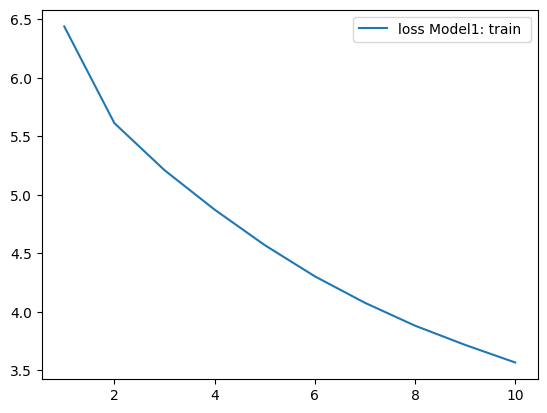

In [266]:
# Entrenamiento
epoch_count = range(1, len(hist1.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist1.history['loss'], label='loss Model1: train ')
#sns.lineplot(x=epoch_count,  y=hist1.history['loss'], label='Model1: valid')
plt.show()

## Modelo 2

Capas Bidireccionales LTSM y Dense

In [267]:
# Construir el modelo
model2 = Sequential([
    Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)),
    Dropout(0.2),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=64)),
    Dense(vocab_size+1, activation='softmax')
])

# Compilar el modelo
model2.compile(loss=funcion_loss_seleccionada, optimizer='adam')#, metrics=['accuracy'])

# Resumen del modelo
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 5)             44005     
                                                                 
 dropout_1 (Dropout)         (None, 32, 5)             0         
                                                                 
 bidirectional (Bidirection  (None, 32, 128)           35840     
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 8801)             

In [ ]:
# Entrena el modelo con multi-threading
hist2 = model2.fit(X, y, epochs=num_epochs, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32,  workers=num_cores, use_multiprocessing=True)

Epoch 1/10
3685/3685 [==============================] - ETA: 0s - loss: 6.3640
 mean perplexity: 14636.294282883875 

3685/3685 [==============================] - 398s 106ms/step - loss: 6.3640
Epoch 2/10
3685/3685 [==============================] - ETA: 0s - loss: 5.6891
 mean perplexity: 208725.55527132747 

3685/3685 [==============================] - 380s 103ms/step - loss: 5.6891
Epoch 3/10
3685/3685 [==============================] - ETA: 0s - loss: 5.3257
 mean perplexity: 329112.34214511915 

3685/3685 [==============================] - 381s 103ms/step - loss: 5.3257
Epoch 4/10
3685/3685 [==============================] - ETA: 0s - loss: 5.0153
 mean perplexity: 527184.9016021685 

3685/3685 [==============================] - 380s 103ms/step - loss: 5.0153
Epoch 5/10
3685/3685 [==============================] - ETA: 0s - loss: 4.7292
 mean perplexity: 425627.4047402087 

3685/3685 [==============================] - 417s 113ms/step - loss: 4.7292
Epoch 6/10
1324/3685 [=========>

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist2.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['loss'], label='loss Model2: train ')
#sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='Model2: valid')
plt.show()

## Modelo 3

Capas GRU y Dense

In [100]:
print("vocab_size:", vocab_size)
print("max_context_size:", max_context_size)

vocab_size: 8800
max_context_size: 32


In [50]:
# Construir el modelo
model3 = Sequential([
    Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)),
    GRU(units=64, return_sequences=True),
    GRU(units=64),
    Dense(vocab_size+1, activation='softmax')
])

# Compilar el modelo
model3.compile(loss=funcion_loss_seleccionada, optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 5)             44005     
                                                                 
 gru (GRU)                   (None, 32, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 8801)              572065    
                                                                 
Total params: 654662 (2.50 MB)
Trainable params: 654662 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
X

array([[   0,    0,    0, ...,    0,    0, 1769],
       [   0,    0,    0, ...,    0, 1769,   78],
       [   0,    0,    0, ..., 1769,   78,  144],
       ...,
       [   0,    0,    0, ...,    3,  102,   15],
       [   0,    0,    0, ...,  102,   15,  484],
       [   0,    0,    0, ...,   15,  484,    1]], dtype=int32)

In [51]:
# Entrena el modelo con multi-threading
hist3 = model3.fit(X, y, epochs=num_epochs,  callbacks=[PplCallback(tokenized_sentences_val)],  batch_size=32, workers=num_cores, use_multiprocessing=True)

Epoch 1/10
3685/3685 [==============================] - ETA: 0s - loss: 6.2692 - accuracy: 0.0859
 mean perplexity: 11108.670364613838 

3685/3685 [==============================] - 277s 74ms/step - loss: 6.2692 - accuracy: 0.0859
Epoch 2/10
3684/3685 [============================>.] - ETA: 0s - loss: 4.9197 - accuracy: 0.1685
 mean perplexity: 164476.17586632294 

3685/3685 [==============================] - 241s 65ms/step - loss: 4.9195 - accuracy: 0.1686
Epoch 3/10
3684/3685 [============================>.] - ETA: 0s - loss: 4.0275 - accuracy: 0.3032
 mean perplexity: 1643123.2665076358 

3685/3685 [==============================] - 206s 56ms/step - loss: 4.0275 - accuracy: 0.3032
Epoch 4/10
3684/3685 [============================>.] - ETA: 0s - loss: 3.4813 - accuracy: 0.3945
 mean perplexity: 3568808.4376792987 

3685/3685 [==============================] - 219s 60ms/step - loss: 3.4812 - accuracy: 0.3945
Epoch 5/10
3685/3685 [==============================] - ETA: 0s - loss: 3.12

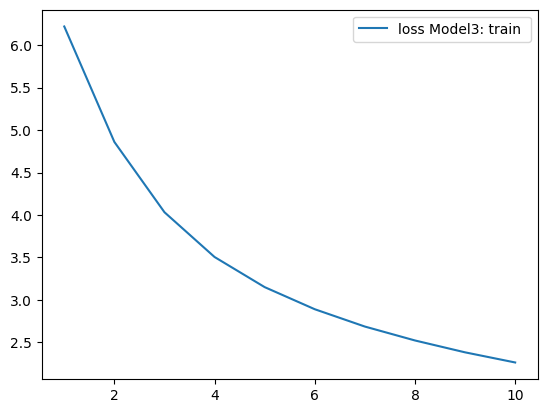

In [53]:
# Entrenamiento
epoch_count = range(1, len(hist3.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['loss'], label='loss Model3: train ')
#sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='Model3: valid')
plt.show()

En todos los modelos entrenados, la perplejidad fue aumentando en cada época de entrenamiento (en lugar de bajar que es lo esperado).
De los tres modelos, el que resulta con menor perplejidad (y menor loss) es el Modelo 3 (con capas GRU y Dense), por lo tanto el modelo seleccionado es ese.

In [52]:
model_elegido = model3

## Predicción de la próxima palabra

In [ ]:
#!pip uninstall -y typer
#!pip install typer>=0.3.0

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
import gradio as gr

In [ ]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model_elegido.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresponde al índice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Verificamos si out_word está vacío
    if out_word:
        # Agregamos la palabra a la frase predicha
        return human_text + ' ' + out_word
    else:
        # Si out_word está vacío, devolvemos solo human_text
        return human_text

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)


Ejemplo obtenido:

comenzé con las palabras: "el alimento trajo". Después fui agregando una a una las palabras que predecía y el resultado final fue: "el alimento trajo la sociedad de que en el simple número de kalahari y el de siguiente no gozaban a la tierra de que recolectores".

Aunque las palabras pueden ser del contexto correcto, la oración obtenida no es coherente.

## Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='el alimento trajo las bandas vecinas'

generate_seq(model_elegido, tok, input_text, max_length=max_context_size, n_words=10)

**input_text 1**

'el alimento trajo'

**Resultado 1**:

"el alimento trajo las bandas vecinas son pueden un orden fuera de una"

**Conclusión 1**:

hasta la 3 palabra predicha la oración pareciera tener sentido, luego ya no. Entonces, lo recomendable es predecir tal vez una cantidad de palabras no mayor a la cantidad brindada en el input_text.

-------------

**input_text 2**

'el alimento trajo las bandas vecinas'

**Resultado 2**:

"el alimento trajo las bandas vecinas son pueden un orden fuera de una compañía en navegantes"

**Conclusión 2**:

agregar más palabras en el input_text no mejoró la predicción.


# Segunda parte del trabajo práctico

In [47]:
from keras.models import load_model

In [53]:
# Ruta de guardado del modelo
# en google colab
ruta_modelo = '/content/drive/MyDrive/Colab Notebooks/NLP_TP/Desafio3/model_elegido.keras'
# en PC
#ruta_modelo = './Desafio3/model_elegido.keras'

# Guardar el modelo
#model_elegido.save(ruta_modelo)

# Recuperar el modelo
#model_elegido = keras.models.load_model(ruta_modelo)


In [54]:
model_elegido.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 5)             44005     
                                                                 
 gru (GRU)                   (None, 32, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 8801)              572065    
                                                                 
Total params: 654662 (2.50 MB)
Trainable params: 654662 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

###  Beam search y muestreo aleatorio

In [69]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [70]:
# predicción con beam search
salidas = beam_search(model_elegido,num_beams=10,num_words=6,input="el alimento trajo")

1/1 [==============================] - 0s 24ms/step


In [71]:
# veamos las salidas
for i in range(10):
    print(decode(salidas[i]))


['el alimento trajo el plan fracasó en una resistiera']
['el alimento trajo el plan fracasó en parte las']
['el alimento trajo el plan fracasó en parte requiere']
['el alimento trajo el plan fracasó en una cristal']
['el alimento trajo el plan fracasó en parte de']
['el alimento trajo el plan fracasó en parte a']
['el alimento trajo el plan fracasó en una tanto']
['el alimento trajo el plan fracasó en una sociedad']
['el alimento trajo el plan fracasó en parte o']
['el alimento trajo el plan fracasó en parte a']


### más pruebas: greedy_search y beam_search

In [243]:
def greedy_search(model, start_encoded, max_len, temperature):
    # Inicializamos la secuencia de salida con la secuencia de inicio
    sequence = tf.identity(start_encoded)

    for _ in range(max_len):
        # Generamos las probabilidades de las palabras siguientes
        next_token_probs = model.predict(sequence)[0][-1]
        print("next_token_probs: ", next_token_probs) ### borrar cuando ok

        # Aplicamos la temperatura
        next_token_probs = np.log(next_token_probs) / temperature
        exp_probs = np.exp(next_token_probs)
        next_token_probs = exp_probs / np.sum(exp_probs)

        # Elegimos la palabra siguiente basada en las probabilidades
        next_token = np.argmax(next_token_probs)
        print("next_token: ", next_token) ### borrar cuando ok
        next_token = np.array([[next_token]])  # NUEVO CODIGO
        sequence = tf.concat([sequence, next_token], axis=1)   # NUEVO CODIGO
        print("sequence: ", sequence) ### borrar cuando ok
        # Si alcanzamos el token de fin o la longitud máxima, detenemos la generación
        if sequence.shape[1] >= max_len or  next_token == end_token  :
            #print("borrarrrrrrrrr porque  ok")
            break

    return sequence



In [222]:
def beam_search(model, start_encoded, max_len, beam_width, temperature, stochastic=False):
    # Inicializamos el beam con una sola secuencia conteniendo la secuencia de inicio
    beam = tf.identity(start_encoded)
    print("beam.shape: ", beam.shape) ### borrar cuando ok
    print("beam[0]: ", beam) ### borrar cuando ok


    # Iteramos hasta alcanzar la longitud máxima
    print("max_len: ", max_len) ### borrar cuando ok

    for i in range(max_len):
        print("i: ", i) ### borrar cuando ok

        # Expandimos el beam
        new_beam = []
        print("inicializacion new_beam", new_beam)

        for seq in beam:
            print("seq.shape: ", seq.shape) ### borrar cuando ok
            seq = tf.expand_dims(seq, axis=0)  # CAMBIO: Agrega una dimensión de tiempo adicional
            print("seq.shape nueva dimension: ", seq.shape) ### borrar cuando ok

            ##next_token_probs = model.predict(np.array([seq]))[0][-1] # original
            new_seq_array = np.array(seq)#  CAMBIO

            next_token_probs = model.predict(new_seq_array) #  CAMBIO
            #next_token_probs = model.predict([seq])[0][-1] # CAMBIO
            ##next_token_probs = model.predict(np.array([seq[-1]]))[0][-1] #  CAMBIO

            print("next_token_probs: ", next_token_probs) ### borrar cuando ok
            print("next_token_probs.shape: ", next_token_probs.shape) ### borrar cuando ok

            # Aplicamos la temperatura
            print("temperatura: ", temperature) ### borrar cuando ok
            next_token_probs = np.log(next_token_probs) / temperature
            exp_probs = np.exp(next_token_probs)
            print("exp_probs: ", exp_probs) ### borrar cuando ok
            print("np.sum(exp_probs): ", np.sum(exp_probs)) ### borrar cuando ok
            next_token_probs = exp_probs / np.sum(exp_probs)
            print("next_token_probs_temp: ", next_token_probs) ### borrar cuando ok



            # Ordenamos las probabilidades de las palabras siguientes en orden descendente
            print("indices: ", np.argsort(next_token_probs)) ### borrar cuando ok
            sorted_indices = np.argsort(next_token_probs)[::-1]
            print("sorted_indices: ", sorted_indices) ### borrar cuando ok

            # Expandimos el beam con las mejores palabras siguientes (basado en el beam width)
            print("min(beam_width, len(sorted_indices)): ", min(beam_width, len(sorted_indices)))
            print("beam_width: " , beam_width)
            print("len(sorted_indices): " , len(sorted_indices))

            for i in range(min(beam_width, len(sorted_indices))):

                ## mix de codigo ORIGINAL + CAMBIOS
                # print("i, expandimos el beam : ", i ) ### borrar cuando ok
                # token_index = sorted_indices[i] # original
                # print("......token_index, expandimos el beam : ", token_index.shape ) ### borrar cuando ok
                # new_seq = seq + [token_index]
                # print("new_seq, expandimos el beam : ", new_seq ) ### borrar cuando ok
                # new_beam.append(new_seq)

                ## NUEVO bloque de codigo
                print("i, expandimos el beam : ", i ) ### borrar cuando ok
                token_index = sorted_indices[i]
                print("......token_index, expandimos el beam : ", token_index.shape ) ### borrar cuando ok
                token_index = tf.expand_dims(token_index, axis=0)  # Agrega una dimensión extra
                token_index = tf.cast(token_index, tf.int32)
                print("......token_index, expandimos el beam : ", token_index.shape ) ### borrar cuando ok
                new_seq = tf.concat([seq, token_index], axis=1)  # Concatenar a lo largo de la dimensión de la secuencia
                print("......new_seq.shape  : ", new_seq.shape  )
                print("......new_seq= tf.concat([seq, token_index], axis=1)  : ", new_seq ) ### borrar cuando ok
                new_beam.append(new_seq)  # Agregar la nueva secuencia expandida a new_beam


        # Filtramos las secuencias que exceden la longitud máxima
        ## new_beam = [seq for seq in new_beam if len(seq) <= max_len]
        # filtered_beam = [] ## pruebo comentar
        # for seq in new_beam:
        #     if len(seq) <= max_len:
        #         filtered_beam.append(seq)
        # new_beam = filtered_beam

        # Depuración: Imprimir las secuencias generadas después de la expansión
        print(" ::::::::::::: new_beam:", new_beam)

#####################################################  ESTOCÁSTICO

        # Ordenamos el beam basado en las probabilidades acumuladas
        if stochastic:
            # Si se utiliza beam search estocástico, seleccionamos secuencias basadas en muestreo estocástico
            print(" ::::::::::::: dentro de stochastic ") ### borrar cuando ok


            ############ CODIGO ORIGINAL
            # if new_beam:
            #     # beam_probs = [np.prod(model.predict(np.array([seq]))[0][-1]) for seq in new_beam] ## ORIGINAL
            #     beam_probs = [np.prod(model.predict(np.array([seq.numpy()]))[0][-1]) for seq in new_beam] ## CAMBIO
            #     beam_probs /= np.sum(beam_probs)  # Normalizamos las probabilidades
            #     chosen_indices = np.random.choice(len(new_beam), size=min(beam_width, len(new_beam)), replace=False, p=beam_probs)
            #     beam = [new_beam[idx] for idx in chosen_indices]
            # else:
            #     print(" ---- no existe new_beam ") ### borrar cuando ok
            #     break

            ############ CODIGO NUEVO
            for seq_i in new_beam:
                if seq_i  is None:
                    print("Se encontró una secuencia None en new_beam.")
                else:
                    print("La secuencia no es None:", seq_i )

            if new_beam:
                beam_probs = []
                for seq in new_beam:
                    if seq is not None:
                        last_32_elements = [tensor[0, 3:32+3] for tensor in new_beam] ## CAMBIO
                        print("------- antes del predict" ) ### borrar cuando ok
                        print("len(last_32_elements):" , len(last_32_elements)) ### borrar cuando ok
                        seq_array = seq_array = tf.stack(last_32_elements).numpy()#last_32_elements.numpy()
                        prediction = [(x, np.prod(model.predict(np.expand_dims(x, axis=0))[0][-1])) for x in last_32_elements if x is not None] ## prediction = [(x, np.prod(model.predict(np.array([x]))[0][-1])) for x in last_32_elements if x is not None]
                        print("------- pasó el predict" ) ### borrar cuando ok
                        # beam_probs = [prob for _, prob in prediction]  # Extraer solo las probabilidades
                        # beam_prod = np.prod(beam_probs)  # Calcular el producto de las probabilidades
                        # beam_probs.append(beam_prod)  # Agregar el producto al beam_probs
                        beam_probs.extend([prob for _, prob in prediction])
                        print("beam_probs:", beam_probs ) ### borrar cuando ok
                        print("len(beam_probs):", len(beam_probs) ) ### borrar cuando ok
                        print("------- despues de append el predict" ) ### borrar cuando ok
                    else:
                        print("La secuencia  es None:" ) ### borrar cuando ok
                        beam_probs.append(0)  # Si la secuencia es None, asigna una probabilidad de cero
                beam_probs /= np.sum(beam_probs)
                print("Número de elementos en new_beam: ", len(new_beam)) ### borrar cuando ok
                print("beam_probs.shape: ", beam_probs.shape  ) ### borrar cuando ok
                chosen_indices = np.random.choice(len(new_beam), size=min(beam_width, len(new_beam)), replace=False, p=beam_probs)
                beam = [new_beam[idx] for idx in chosen_indices]
            else:
                print(" ---- no existe new_beam ")
                break

##################################################### DETERMINISTA
        else:
            # Si se utiliza beam search determinista, seleccionamos las mejores secuencias basadas en las probabilidades acumuladas

            print(" ::::::::::::: dentro de determinista ") ### borrar cuando ok

            # beam = sorted(new_beam, key=lambda x: np.prod(model.predict(np.array([x]))[0][-1]), reverse=True)[:beam_width] ## ORIGINAL

            ##beam = sorted(new_beam, key=lambda x: np.prod(model.predict(np.array([x]))[0][-1]) if x is not None else 0, reverse=True)[:beam_width] ## CAMBIO
            ## código "CAMBIO" desfactorizado:
            for seq_i in new_beam:
                if seq_i  is None:
                    print("Se encontró una secuencia None en new_beam.") ### borrar cuando ok
                else:
                    print("La secuencia no es None:", seq_i ) ### borrar cuando ok

            last_32_elements = [tensor[0, 3:32+3] for tensor in new_beam] ## CAMBIO
            #last_32_elements = [tensor[0, -32:] for tensor in new_beam] ## CAMBIO OK
            # Creamos una lista de tuplas (secuencia, probabilidad_acumulada)
            beam_with_probs = [(x, np.prod(model.predict(np.array([x]))[0][-1])) for x in last_32_elements if x is not None]
            print("------- pasó el predict" ) ### borrar cuando ok
            # Ordenamos las secuencias con respecto a las probabilidades acumuladas en orden descendente
            sorted_beam_with_probs = sorted(beam_with_probs, key=lambda x: x[1], reverse=True)
            print("------- pasó el sorted_beam_with_probs " ) ### borrar cuando ok
            # Seleccionamos las primeras "beam_width" secuencias ordenadas
            beam = [x[0] for x in sorted_beam_with_probs][:beam_width]
            print("------- pasó el beam " ) ### borrar cuando ok

            print(" ::::::::::::: beam determinista: ", beam ) ### borrar cuando ok

##################################################### RETURN BEAM

        # Si el beam está vacío, detenemos la generación
        if len(beam) == 0:
            print(" ::::::::::::: dentro de: beam vacío ") ### borrar cuando ok
            break

    return beam





In [247]:
# la frase de inicio
max_sequence_length = 32 # Definir la longitud deseada de la secuencia
start_text = "el alimento trajo" # Convertir la frase de inicio en una lista de tokens
start_tokens = start_text.split()

encoded = encode(start_tokens)  # Codificar la secuencia de inicio
print("encoded:", encoded)
print("encoded.shape:", encoded.shape)


encoded: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    7  529 6481]]
encoded.shape: (1, 32)


In [252]:
# longitud máxima deseada de la secuencia
num_words = 6
temperature = 0.7

# pruebas con greedy search
greedy_sequence = greedy_search(model=model_elegido, start_encoded=encoded, max_len=num_words, temperature=temperature)




1/1 [==============================] - 0s 50ms/step
next_token_probs:  1.6821114e-06
next_token:  0
sequence:  tf.Tensor(
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    7  529 6481    0]], shape=(1, 33), dtype=int32)


In [232]:
# longitud máxima deseada de la secuencia
num_words = 6
beam_width = 1
temperature=0.5

# pruebas con beam search determinista
beam_sequence_deterministic1 = beam_search(model_elegido, start_encoded=encoded, max_len=num_words, beam_width=beam_width, temperature=temperature, stochastic=False)

print("beam_sequence_deterministic", beam_sequence_deterministic1)



beam.shape:  (1, 32)
beam[0]:  tf.Tensor(
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    7  529 6481]], shape=(1, 32), dtype=int32)
max_len:  6
i:  0
inicializacion new_beam []
seq.shape:  (32,)
seq.shape nueva dimension:  (1, 32)
1/1 [==============================] - 0s 27ms/step
next_token_probs:  [[2.7175482e-11 6.5049738e-02 8.5623628e-03 ... 2.8153829e-07
  1.2401798e-06 1.6821114e-06]]
next_token_probs.shape:  (1, 8801)
temperatura:  0.5
exp_probs:  [[7.3850563e-22 4.2314688e-03 7.3314026e-05 ... 7.9263812e-14
  1.5380463e-12 2.8294992e-12]]
np.sum(exp_probs):  0.054919593
next_token_probs_temp:  [[1.3447034e-20 7.7048436e-02 1.3349339e-03 ... 1.4432702e-12
  2.8005421e-11 5.1520760e-11]]
indices:  [[4380 4278 3151 ...   17    8    6]]
sorted_indices:  [[4380 4278 3151 ...   17    8    6]]
min(beam_width, len(sorted_indices)):  1
beam_width:  1
len(sorted_indices):  1
i, ex

In [226]:
# longitud máxima deseada de la secuencia
num_words = 6
beam_width = 1
temperature=0.7

# pruebas con beam search determinista
beam_sequence_deterministic2 = beam_search(model_elegido, start_encoded=encoded, max_len=num_words, beam_width=beam_width, temperature=temperature, stochastic=False)

print("beam_sequence_deterministic", beam_sequence_deterministic2)


beam.shape:  (1, 32)
beam[0]:  tf.Tensor(
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    7  529 6481]], shape=(1, 32), dtype=int32)
max_len:  6
i:  0
inicializacion new_beam []
seq.shape:  (32,)
seq.shape nueva dimension:  (1, 32)
1/1 [==============================] - 0s 36ms/step
next_token_probs:  [[2.7175482e-11 6.5049738e-02 8.5623628e-03 ... 2.8153829e-07
  1.2401798e-06 1.6821114e-06]]
next_token_probs.shape:  (1, 8801)
temperatura:  0.7
exp_probs:  [[8.0531769e-16 2.0166777e-02 1.1131718e-03 ... 4.3872861e-10
  3.6485568e-09 5.6392486e-09]]
np.sum(exp_probs):  0.24337263
next_token_probs_temp:  [[3.3089903e-15 8.2863785e-02 4.5739398e-03 ... 1.8027031e-09
  1.4991647e-08 2.3171252e-08]]
indices:  [[4380 4278 3151 ...   17    8    6]]
sorted_indices:  [[4380 4278 3151 ...   17    8    6]]
min(beam_width, len(sorted_indices)):  1
beam_width:  1
len(sorted_indices):  1
i, exp

In [233]:
# # pruebas con beam search estocástico
# num_words = 6
# beam_width = 1

# beam_sequence_stochastic = beam_search(model_elegido, start_encoded=encoded, max_len=num_words, beam_width=beam_width, temperature=0.5, stochastic=True)

# print("beam_sequence_stochastic", beam_sequence_stochastic)

## Conclusiones

In [253]:
# # Veamos las salidas

print("Salidas de greedy_sequence:")
for i in range(1):
    print(decode(greedy_sequence[i].numpy()))

print('  ')
print(' ================================== ')

print("Salidas de beam search determinista 1:")
#for i in range(len(beam_sequence_deterministic)):
#print("encoded: ", beam_sequence_deterministic1[i])
print("decoded: ", decode(beam_sequence_deterministic1[i].numpy()))

print('  ')
print(' ================================== ')

print("Salidas de beam search determinista 2:")
#for i in range(len(beam_sequence_deterministic)):
#print("encoded: ", beam_sequence_deterministic2[i])
print("decoded: ", decode(beam_sequence_deterministic2[i].numpy()))

print('  ')
print(' ================================== ')

# print("Salidas de beam search estocástico:")
# for i in range(1):
#     print(decode(beam_sequence_stochastic[i].numpy()))



Salidas de greedy_sequence:
['el alimento trajo']
  
Salidas de beam search determinista 1:
decoded:  ['el alimento trajo comprendido modificar «animistas» aletas comprendido prohibido comprendido árabe implicó comprendido árabe implicó comprendido árabe implicó comprendido árabe implicó']
  
Salidas de beam search determinista 2:
decoded:  ['el alimento trajo comprendido modificar «animistas» aletas comprendido prohibido comprendido árabe implicó comprendido árabe implicó comprendido árabe implicó comprendido árabe implicó']
  


greedy_search:
En el caso de greedy_search no logré que prediga palabras concretas, el token predicho para las distintas pruebas realizadas siempre fue cero. Por lo tanto, la palabra resultante era nula. La propuesta para este caso es probar más variaciones de hiperparámetros.

beam_search determnístico:
La secuencia completa no tiene sentido y además se empiezan a repetir palabras.

Pasos a seguir:
* construir un modelo más complejo.